## Robot@Home 2 - Labeled RGBD observations `v1.2`

`R@H2 notebook series`   

<a href="https://colab.research.google.com/github/goyoambrosio/RobotAtHome2/blob/master/notebooks/50-RGBD-observations.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>



### R@H2 functions introduced in this notebook:



-   `rh.get_RGBD_files(id)`
-   `rh.get_RGBD_labels(id, masks)`
-   `get_labeled_image(labels_with_masks, rgb_filename)`
-   `plot_labeled_img(labels_with_masks, rgb_filename)`



### Initial requirements



Install Robot@Home2 Toolbox using the Python package manager



In [1]:
!pip install robotathome

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 836 kB 7.1 MB/s 
     |████████████████████████████████| 58 kB 3.1 MB/s 


Check that the installation has been successful



In [2]:
import robotathome as rh
print (rh.__version__)

1.0.5


#### Using Google Colab and Google Drive



If you haven't yet mounted R@H2 Dataset public share on your Google Drive click
[this](https://drive.google.com/drive/folders/15fQwm4G3hHQR5vI9q0CVDlwxMwaJheC8?usp=sharing).

In order to access from Google Colab it's mandatory to create a `shorcut`. You
just need to select the shared folder `Shared with me > R@H2-2.0.1`, right click
and select the corresponding menu option `Add Shortcut to Drive`. Now, a new
folder (actually a shortcut) with the same name will appear under `My Drive`.

Next, mount Google Drive in Google Colab. The browser will ask for the
authorization to access the Google Drive account. Sign in to your Google account
and Google Drive will be mounted to `/content/drive`. Note that the R@H2 files are
located in the `/content/drive/MyDrive/R@H2-2.0.1` folder.



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


More info in [this notebook](https://colab.research.google.com/github/goyoambrosio/RobotAtHome2/blob/master/notebooks/05-Google-colab-drive.ipynb).



### Importing R@H2



In [4]:
%matplotlib inline

import numpy as np
import os
import pandas as pd

from robotathome import RobotAtHome
from robotathome import logger, log, set_log_level
from robotathome import time_win2unixepoch, time_unixepoch2win
from robotathome import get_labeled_img, plot_labeled_img

In [5]:
log.set_log_level('INFO')  # SUCCESS is the default

level_no, level_name = log.get_current_log_level()
print(f'Current log level name: {level_name}')

Current log level name: INFO


### Instantiating the toolbox



The toolbox is modeled around the RobotAtHome class, so we'll begin instantiating it and
creating a working object.

The RobotAtHome class has some attributes:

-   `rh_path` : string with the full path for robotathome database, usually `rh.db`.
    Its default value is `'.'` (the current directory)
-   `wspc_path` : string with the full path where results or temporary files are
    stored. It's the path to the workspace directory. Its default value also is
    `'.'`.
-   `db_filename` : string with the database filename. Its default value is `'rh.db'`
-   `rgbd_path` : string with the full path to where RGBD images are stored. Its default value is
    `'./files/rgbd'`.
-   `scene_path` : string with the full path to where Scene (3D) images are stored. Its
    default value is `'./files/scene'`.

We assume that we are running this notebook in Google Colab. Therefore our
folder structure is as follows:

    /content/drive
    └─── MyDrive
         ├─── R@H2-2.0.1
         │    └── files
         │        ├── rgbd
         │        └── scene
         └─────── rh.db

Let's instantiate our first, and usually the only one, object:



In [6]:
my_rh_path = '/content/drive/MyDrive/R@H2-2.0.1'
my_rgbd_path = os.path.join(my_rh_path, 'files/rgbd')
my_scene_path = os.path.join(my_rh_path, 'files/scene')
my_wspc_path = '/content'

try: 
      rh = RobotAtHome(my_rh_path, my_rgbd_path, my_scene_path, my_wspc_path)
except:
      logger.error("Something was wrong")

2022-06-05 01:08:14.752 | SUCCESS  | robotathome.core.reader:__open_dataset:85 - Connection is established: rh.db


Now you are ready to dive into the R@H2 database. Following we'll show a set of
functions to extract some of the main reference data.



### Introduction



As we've seen in the previous notebook, there is a set of RGBD observations from
the four RGB-D cameras, including intensity images and depth images. There is
also a subset of observations that have been processed to include per-pixel
object labels.



In [7]:
# The full dataset is returned by default
lblrgbd = rh.get_sensor_observations('lblrgbd')
print(f"# Labeled RGBD set: {len(lblrgbd)} observations with {len(lblrgbd.columns)} fields")

# Labeled RGBD set: 32937 observations with 14 fields


Apart from the information included in each record,



In [8]:
print(lblrgbd.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32937 entries, 0 to 32936
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  32937 non-null  int64  
 1   timestamp           32937 non-null  int64  
 2   home_session_id     32937 non-null  int64  
 3   home_subsession_id  32937 non-null  int64  
 4   home_id             32937 non-null  int64  
 5   room_id             32937 non-null  int64  
 6   sensor_id           32937 non-null  int64  
 7   sensor_name         32937 non-null  object 
 8   sensor_pose_x       32937 non-null  float64
 9   sensor_pose_y       32937 non-null  float64
 10  sensor_pose_z       32937 non-null  float64
 11  sensor_pose_yaw     32937 non-null  float64
 12  sensor_pose_pitch   32937 non-null  float64
 13  sensor_pose_roll    32937 non-null  float64
dtypes: float64(6), int64(7), object(1)
memory usage: 3.5+ MB
None


For labeled RGBD observations there is information related to the files
containing the RGB and depth images, as well as the labels of the objects.



### Files



There are two files per RGBD observation, one for the RGB data and one for depth
(D) data



In [9]:
# Let's look any observation, e.g. id = 100000
id = 100000
[rgb_f, d_f] = rh.get_RGBD_files(id)
logger.info("Sensor observation {} files\n RGB file   : {}\n Depth file : {}", id, rgb_f, d_f )

2022-06-05 01:08:38.629 | INFO     | __main__:<module>:4 - Sensor observation 100000 files
 RGB file   : /content/drive/MyDrive/R@H2-2.0.1/files/rgbd/session_1/alma/bathroom1/subsession_1/100000_intensity.png
 Depth file : /content/drive/MyDrive/R@H2-2.0.1/files/rgbd/session_1/alma/bathroom1/subsession_1/100000_depth.png


With the full path filenames it's easy to visualize them.



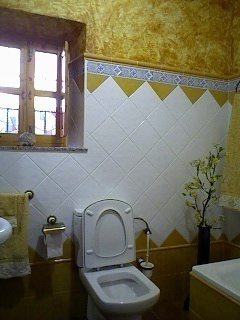

In [10]:
from IPython.display import Image
Image(rgb_f)

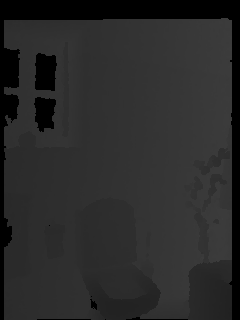

In [11]:
Image(d_f)

The images can be easily read as arrays to work with them



<class 'numpy.ndarray'>


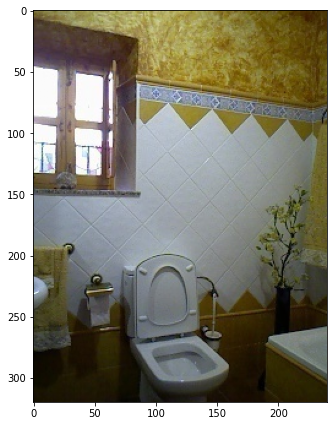

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Default (inches): rcParams["figure.figsize"] = [6.4, 4.8]
plt.rcParams['figure.figsize'] = [9.6, 7.2]

rgb_img = mpimg.imread(rgb_f)
# rgb_img is a numpy array
print(type(rgb_img))

# Another way to visualize it
imgplot = plt.imshow(rgb_img)

### Labels



Labels are object annotations for each RGBD observation.



In [13]:
# Let's follow with the previous example
id = 100000
# Notice the masks parameter indicating that we are not interested
# in the corresponding label masks at this time, resulting in a faster
# response
labels = rh.get_RGBD_labels(id, masks = False)
# labels is a dataframe with the object annotations for the
# RGBD observation
logger.info("\nlabels: \n{}", labels)

2022-06-05 01:09:29.008 | INFO     | __main__:<module>:9 - 
labels: 
    id  local_id            name  sensor_observation_id  object_type_id
0    0         1        window_0                 100000               5
1    1         2         towel_0                 100000               6
2    2         3    paper_roll_0                 100000               7
3    3         4        toilet_0                 100000               8
4    4         5  toilet_brush_0                 100000               9
5    5         6         plant_0                 100000              10
6    6         7         towel_1                 100000               6
7    7         8          bath_0                 100000              11
8    8         9          wall_1                 100000              13
9    9        10          wall_2                 100000              13
10  10        11         floor_0                 100000              14


Note the following fields, `local_id` is the local reference index for each image,
and `object_type_id` can be used to get the name of the object category.



In [14]:
# For example, let's get the category name of the fourth label
label_category_name = rh.id2name(labels.loc[3,'object_type_id'], 'ot')
print(f"4th label's object type/category: {label_category_name}")

4th label's object type/category: toilet


Usually, we'll work with label/category masks. A label mask is a 2D binary array
where each value corresponds to a pixel, being 1 if belongs to the label and 0
otherwise.



In [15]:
# In this case we'll get a dataframe similar to the previous one
# but with an added mask column
labels_with_masks = rh.get_RGBD_labels(id)
# labels is a dataframe with the object annotations for the RGBD observation
logger.info("\nlabels with masks: \n{}", labels_with_masks)

2022-06-05 01:09:42.191 | INFO     | __main__:<module>:5 - 
labels with masks: 
    id  local_id            name  sensor_observation_id  object_type_id  \
0    0         1        window_0                 100000               5   
1    1         2         towel_0                 100000               6   
2    2         3    paper_roll_0                 100000               7   
3    3         4        toilet_0                 100000               8   
4    4         5  toilet_brush_0                 100000               9   
5    5         6         plant_0                 100000              10   
6    6         7         towel_1                 100000               6   
7    7         8          bath_0                 100000              11   
8    8         9          wall_1                 100000              13   
9    9        10          wall_2                 100000              13   
10  10        11         floor_0                 100000              14   

                   

These binary masks can be easily visualized.



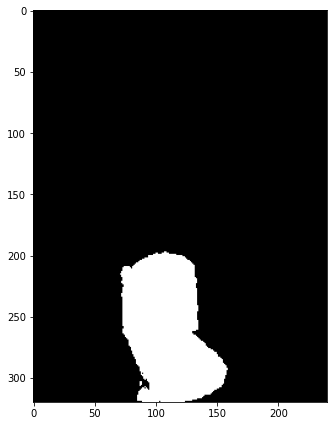

In [16]:
# Again, we choose the previous label, i.e. the toilet
label_binary_mask = labels_with_masks.loc[3,'mask']
plt.imshow(label_binary_mask, cmap='gray')

Sometimes it's good to get a full labels view, i.e., all label masks



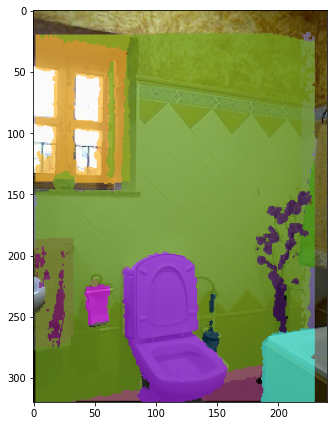

In [20]:
# The following function returns an image patched with labels which
# can be easily plotted
[labeled_img, _] = get_labeled_img(labels_with_masks, rgb_f)
plt.imshow(labeled_img)
plt.show()

Even more, for illustrative purposes it's nice to add a legend



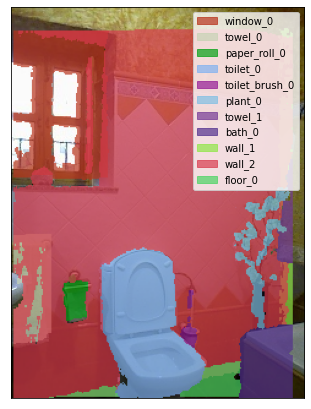

In [21]:
plot_labeled_img(labels_with_masks, rgb_f)

<a href="https://colab.research.google.com/github/goyoambrosio/RobotAtHome2/blob/master/notebooks/50-RGBD-observations.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

